<a href="https://colab.research.google.com/github/Blvisse/Alzheimers-Detection/blob/model_building/AlZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/MRI-SCANS/

/content/drive/MyDrive/MRI-SCANS


In [3]:
import os
os.listdir()

['test',
 'train',
 '.neptune',
 '.ipynb_checkpoints',
 'alldata',
 'model.pkl',
 'inception-v3']

In [4]:
#This script loads and prepares the data set  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging 

import os 
from distutils.dir_util import copy_tree, remove_tree
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from random import randint



# logging.basicConfig(filename='../logs/load_data.log', filemode='w', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',level=logging.INFO)
data_directory = '/content/drive/MyDrive/MRI-SCANS/'
new_directory = os.path.join(data_directory,'alldata')

class PREP:
    

    def __init__(self):
        pass


    def pre_process(self):

        try:

            test_directory = os.path.join(data_directory,'test')
            train_directory = os.path.join(data_directory,'train')
            print(" ================ Folder found ================= \n")
            print(" ==== Contents of train directory ========= \n",os.listdir(train_directory),"\n")
            print(" ==== Contents of test directory ========= \n",os.listdir(test_directory),"\n")

        except FileNotFoundError as e:
            logging.info(' !!! Error the file was not found !!!! ')
            print("!!!! Error the file path doesn't exist !!!! {} ".format(e.__class__))


        print("================ Creating new working tree ================")
        # os.mkdir(new_directory)
        copy_tree(train_directory, new_directory)
        copy_tree(test_directory, new_directory)

        #create a new folder and store all the data in it
        print("========= Creating directory ========= \n")
        print(" ============ new directory contains ======== \n")
        logging.info("========= created  directory =========")
        logging.info("os.listdir(new_directory)")
        print(os.listdir(new_directory))


        #The images have been classified in the respective folders and we shall use thos as classes
        classes=os.listdir(new_directory)
        print(classes)

        IMG_SIZE=176
        IMAGE_SIZE=[176,176]
        DIM= (IMG_SIZE,IMG_SIZE)

        #we use image Data Generator from keras to load the images 

        ZOOM = [.99, 1.01]
        BRIGHT_RANGE = [0.8, 1.2]
        HORZ_FLIP = True
        FILL_MODE = "constant"
        DATA_FORMAT = "channels_last"

        work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

        train_data_gen = work_dr.flow_from_directory(directory=new_directory, target_size=DIM, batch_size=6500, shuffle=False)

        return train_data_gen,classes




In [5]:
!pip install tensorflow_addons
!pip install imblearn
!pip install neptune-notebooks
!pip install neptune-client

     |████████████████████████████████| 679 kB 10.7 MB/s 
     |████████████████████████████████| 1.0 MB 11.1 MB/s 
     |████████████████████████████████| 829 kB 47.2 MB/s 
     |████████████████████████████████| 252 kB 48.5 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 170 kB 52.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 129 kB 50.5 MB/s 
     |████████████████████████████████| 67 kB 6.1 MB/s 
  Created wheel for neptune-notebooks: filename=neptune_notebooks-0.9.0-py2.py3-none-any.whl size=1026884 sha256=f2e0491b3cf21ce36778ce066d3401f855b53e3fa01ca2bfbb31ffa64976e3c4
  Stored in directory: /root/.cache/pip/wheels/66/4a/16/5d51a1f2c6aab63b628b950cb8138cf53078890ef3d7759852
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=314fc435c3f14ad34e49e6b4e7160a3ab6bf2ffa3cf1b350289c2e09c0c1127f
  Stored in directory: /root/.cache/pip/wheels/

In [6]:
import neptune.new as neptune

run = neptune.init(project='blaisepke/AlzheimerPred',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlYmViMmY2ZS1jNWFjLTRlMWMtYTdlOS00OGMxOWE0YTAzZDIifQ==') # your credentials



https://app.neptune.ai/blaisepke/AlzheimerPred/e/AL-10
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [7]:
import pandas as pd
import numpy as np
import os
import sys
import logging
import matplotlib.pyplot as plt
from random import randint
import tensorflow as tf
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D



print("TensorFlow Version:", tf.__version__)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 

TensorFlow Version: 2.6.0


In [8]:
load_Instance=PREP()
train_data_gen,classes=load_Instance.pre_process()

 ================ Folder found ================= 

 ==== Contents of train directory ========= 
 ['MildDemented', 'ModerateDemented', 'VeryMildDemented', 'NonDemented'] 

 ==== Contents of test directory ========= 
 ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented'] 

================ Creating new working tree ================
========= Creating directory ========= 

 ============ new directory contains ======== 

['MildDemented', 'ModerateDemented', 'VeryMildDemented', 'NonDemented']
['MildDemented', 'ModerateDemented', 'VeryMildDemented', 'NonDemented']
Found 6400 images belonging to 4 classes.


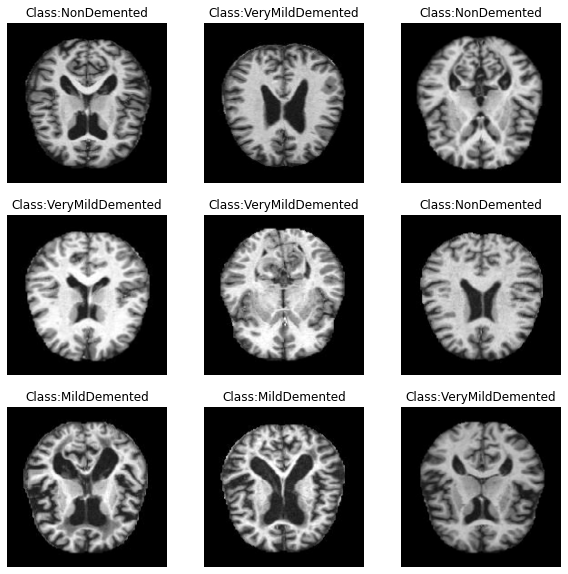

In [9]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], classes))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [10]:
train_data, train_labels = train_data_gen.next()

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*[176,176], 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 176, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 44, 44, 32)        14016     
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        55680     
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       221952    
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)       0 

In [ ]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)
# run["MODEL"] = "CNN"
# run["parameters"] = {"learning_rate": 0.001,
#                      "optimizer": "Adam"}

for epoch in EPOCHS:
    run["train/loss"].log(history.history[metric])
   

In [ ]:
run["train/loss"].log(history.history[METRICS])

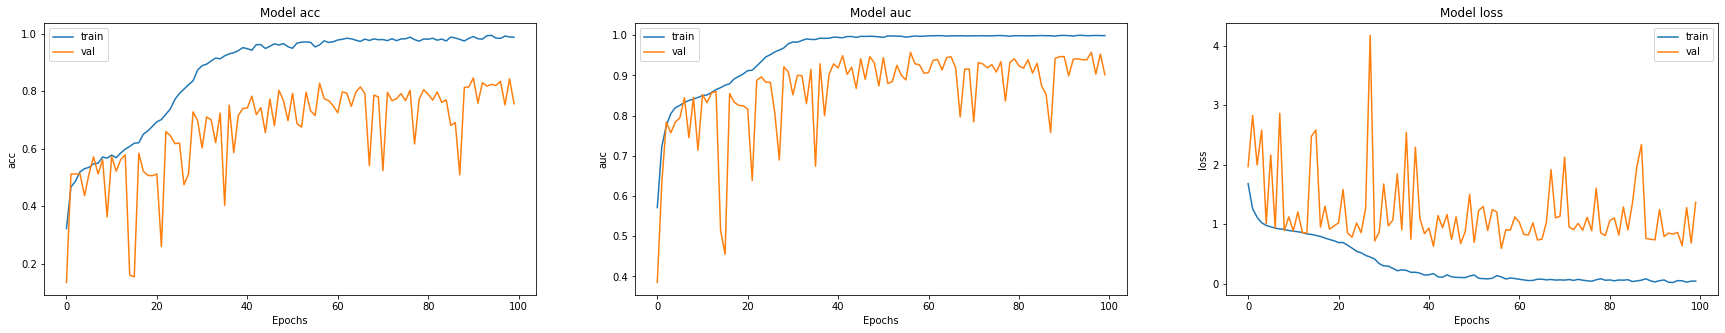

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
#Evaluating the model on the data

test_scores = model.evaluate(test_data, test_labels)

print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

 5/40 [==>...........................] - ETA: 1s - loss: 2.0192 - acc: 0.6938 - auc: 0.8577 - f1_score: 0.5733

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


40/40 [==============================] - 1s 28ms/step - loss: 1.6911 - acc: 0.7383 - auc: 0.8893 - f1_score: 0.6178
Testing Accuracy: 73.83%


In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

87924736/87910968 [==============================] - 2s 0us/step


In [16]:
for layer in inception_model.layers:
    layer.trainable=False

In [17]:
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [19]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization_95 (Batc (None, 512)       

In [20]:
EPOCHS = 100

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
163/163 [==============================] - ETA: 0s - loss: 1.5419 - acc: 0.3461 - auc: 0.6073 - f1_score: 0.3446

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


163/163 [==============================] - 66s 190ms/step - loss: 1.5419 - acc: 0.3461 - auc: 0.6073 - f1_score: 0.3446 - val_loss: 0.9762 - val_acc: 0.5765 - val_auc: 0.8305 - val_f1_score: 0.5283
Epoch 2/100
163/163 [==============================] - 27s 165ms/step - loss: 1.0746 - acc: 0.5211 - auc: 0.7897 - f1_score: 0.5124 - val_loss: 0.7604 - val_acc: 0.6595 - val_auc: 0.8956 - val_f1_score: 0.6007
Epoch 3/100
163/163 [==============================] - 27s 167ms/step - loss: 0.8800 - acc: 0.5990 - auc: 0.8595 - f1_score: 0.5923 - val_loss: 0.6602 - val_acc: 0.6956 - val_auc: 0.9195 - val_f1_score: 0.6857
Epoch 4/100
163/163 [==============================] - 27s 167ms/step - loss: 0.7959 - acc: 0.6368 - auc: 0.8855 - f1_score: 0.6337 - val_loss: 0.6056 - val_acc: 0.7317 - val_auc: 0.9332 - val_f1_score: 0.7220
Epoch 5/100
163/163 [==============================] - 27s 168ms/step - loss: 0.7139 - acc: 0.6787 - auc: 0.9078 - f1_score: 0.6772 - val_loss: 0.5834 - val_acc: 0.7341 - v

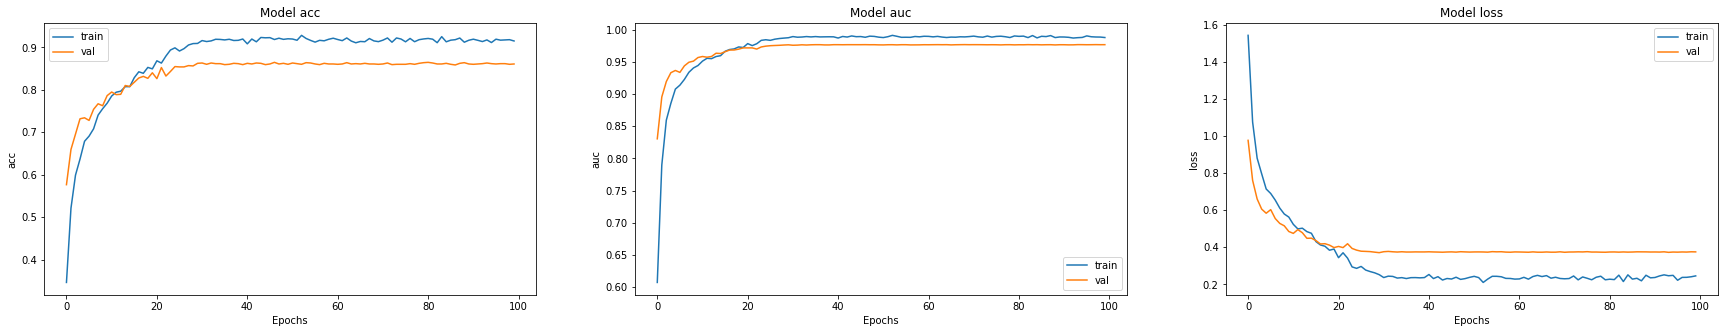

In [21]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [23]:
tf.keras.models.save_model(custom_inception_model,'inceptio-v3.2.hdf5')

In [25]:

run["train/loss"].log(history.history[metric])


In [26]:
custom_inception_model.save('inception', save_format='h5')

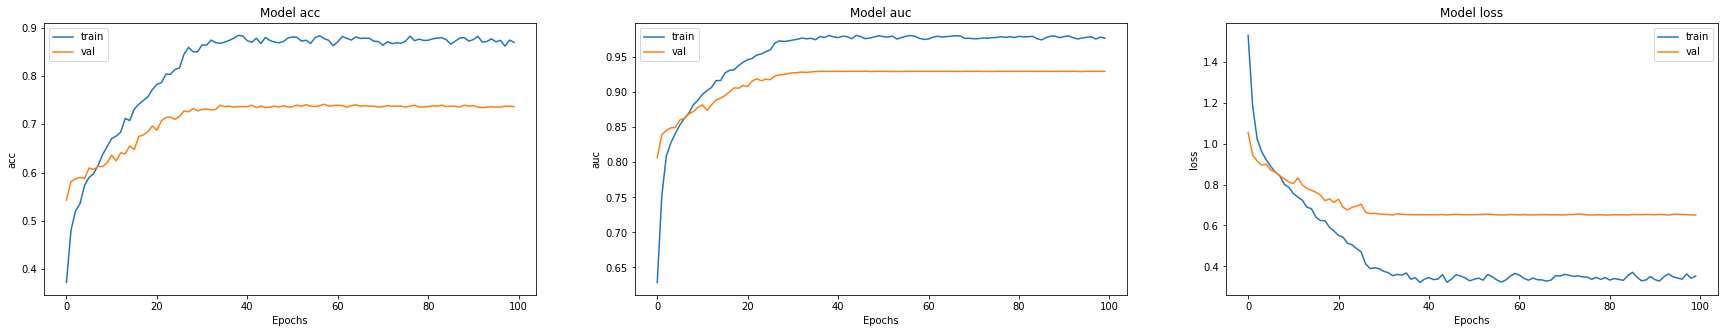

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [27]:
#Evaluating the model on the data


test_scores = custom_inception_model.evaluate(test_data, test_labels)


print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

 1/51 [..............................] - ETA: 10s - loss: 0.1843 - acc: 0.9375 - auc: 0.9945 - f1_score: 0.9417

/usr/local/lib/python3.7/dist-packages/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


51/51 [==============================] - 8s 157ms/step - loss: 0.3667 - acc: 0.8599 - auc: 0.9773 - f1_score: 0.8614
Testing Accuracy: 85.99%


In [ ]:
##we pickle the model
import pickle

In [ ]:
from sklearn.externals import joblib



model.save('inception-v3', save_format='h5')


In [12]:
#trying to get better results by balancing the dataset

"""
This is achieved by using oversmpling of the data

"""

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(8132, 176, 176, 3) (8132, 4)


In [13]:

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [14]:
EPOCHS = 100

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

NameError: ignored

NameError: ignored

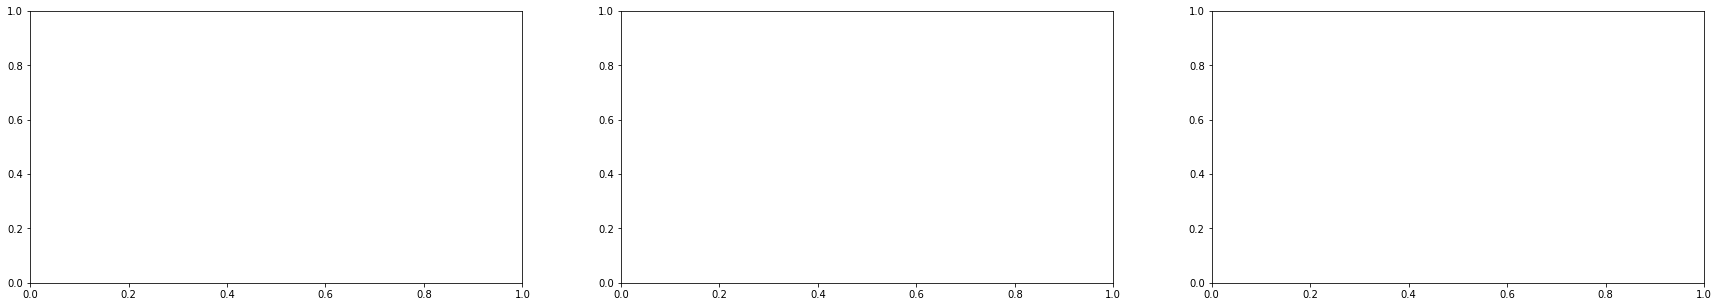

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
tf.keras.models.save_model(model,'.hdf5')